In [3]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from perlin_noise import PerlinNoise

from IPython.display import display, clear_output
from stable_fluid.fluid import Fluid
from matplotlib.collections import LineCollection
from polyline_control.polyline import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#z, y, x순서임.
#근데 speed[0]은 x벡터의 크기, speed[1]은 y벡터의 크, speed[2]는 z벡터의 크기 됨 주의.
RESOLUTION = 200, 200
DX = 0.1 #m 단위.

#단위: 초(second).
COMP_DT = 1 * 1e-6
DT = 1 #simulation sparsity.
FRAME_DT = 1 * 1e-5

EXPLOSION_T = 15
TOTAL_T = 15

#num_polyline = 100
#num_points = 2500

buoyancy_a = 0.1

print(f"total distance x: {RESOLUTION[0] * DX} m")
print(f"total distance y: {RESOLUTION[1] * DX} m")

total distance x: 20.0 m
total distance y: 20.0 m


In [5]:

# Step 1: Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Step 2: 간단한 연산으로 CUDA 초기화 (GPU인 경우)
if device.type == "cuda":
    _ = torch.zeros(1, device=device)  # CUDA 초기화 트리거
    print(f"✓ CUDA initialized: {torch.cuda.get_device_name(0)}")

# Step 3: Fluid 생성
fluid = Fluid(
    RESOLUTION, 
    device=device,
    dx=DX,
    rho_ambient=1.225,
    p_ambient=101325.0,
    T_ambient=288.15
)

Device: cuda
✓ CUDA initialized: NVIDIA GeForce GTX 1660 SUPER


In [12]:
gamma = 1.4  # 이상기체 지수 (공기)

# 중심점 정의
center = torch.tensor([RESOLUTION[0] // 2, RESOLUTION[1] // 2], 
                      dtype=torch.float64, device=device)
dist2 = torch.sum((fluid.indices - center.view(2, 1, 1))**2, dim=0)
dist = torch.sqrt(dist2) * DX  # 실제 거리

# === 주변 공기 초기화 ===
fluid.rho[:] = fluid.rho_ambient  # [kg/m³]
fluid.E[:] = fluid.p_ambient / (gamma - 1.0)  # [J/m³]

# === 폭발 조건 ===
explosion_radius = 30.0  # 그리드 셀 단위
transition_width = 30.0  # 전이 영역 폭 (셀 단위) ← 중요!

explosion_pressure = 1.0e7 / 2  # [Pa] = 10 MPa
explosion_rho = 50.0 * fluid.rho_ambient  # [kg/m³]
explosion_internal_E = explosion_pressure / (gamma - 1.0)  # [J/m³]

# === Smooth Gaussian Profile ===
# exp(-r²/(2σ²)) 형태
sigma = 1  # 표준편차
gaussian_profile = torch.exp(-dist**2 / (2 * sigma**2))

# 압력/밀도/에너지를 smooth하게 보간
# profile: 중심=1.0, 멀리=0.0
fluid.rho[:] = fluid.rho_ambient + (explosion_rho - fluid.rho_ambient) * gaussian_profile
fluid.E[:] = (fluid.p_ambient / (gamma - 1.0) + 
                       (explosion_internal_E - fluid.p_ambient / (gamma - 1.0)) * gaussian_profile)

# 또는 Sigmoid를 사용한 부드러운 전이
#sigmoid_profile = 1.0 / (1.0 + torch.exp((dist - explosion_radius) / transition_width))
#fluid.rho[:] = fluid.rho_ambient + (explosion_rho - fluid.rho_ambient) * sigmoid_profile
#fluid.internal_E[:] = (fluid.p_ambient / (gamma - 1.0) + 
#                       (explosion_internal_E - fluid.p_ambient / (gamma - 1.0)) * sigmoid_profile)

# 초기 속도는 0
fluid.velocity[:] = 0.0

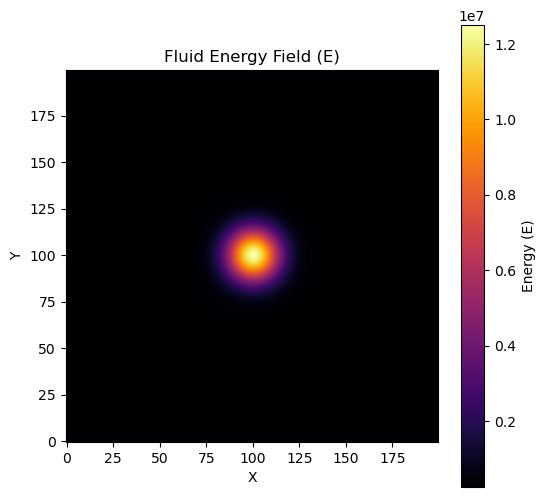

In [13]:
E = fluid.E.detach().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(E, cmap='inferno', origin='lower')
plt.colorbar(label='Energy (E)')
plt.title('Fluid Energy Field (E)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

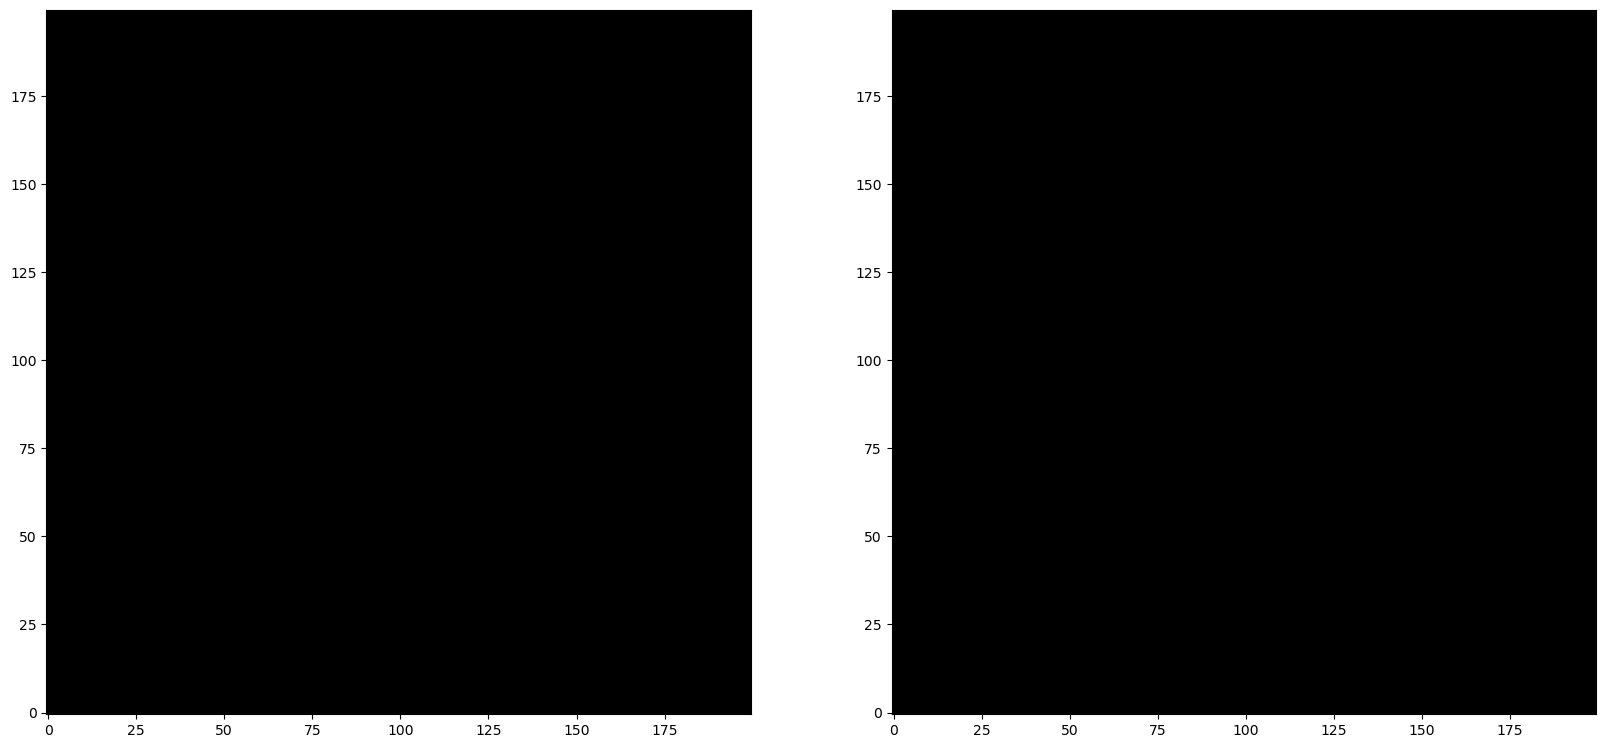

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))  # 1행 2열
im1 = axes[0].imshow(np.zeros(RESOLUTION), cmap='gray', vmin=0, vmax=1, origin="lower")
im2 = axes[1].imshow(np.zeros(RESOLUTION), cmap='gray', vmin=0, vmax=1, origin="lower")

t = 0

def update(frame):
    global t, polylines, inflow_h_mask, inflow_d_mask

    if t <= EXPLOSION_T:
        for i in range(int(FRAME_DT / COMP_DT)):
            #fluid.dye = torch.where(inflow_d_mask, fluid.dye, inflow_dye)
            # CFL 조건 체크 및 verbose 진단 (필요시 verbose=True로 변경)
            delta_E = fluid.comp_step(dt=COMP_DT)
            # delta_E 시각화
            delta_E_cpu = delta_E.detach().cpu().numpy() if hasattr(delta_E, "detach") else np.array(delta_E)
            im2.set_data(delta_E_cpu/ (delta_E_cpu.max() + 1))

            t += COMP_DT
    else:
        for i in range(int(FRAME_DT / DT)):
            fluid.step(dt=DT, eps_conf=0.04)
            #polylines[:, 1:, :] = advect_polylines(fluid.velocity, polylines[:, 1:, :], DT)
            #polylines = redistribute_polyline_points(polylines)
            t += DT

    dye_cpu = fluid.rho.cpu().numpy()
    dye_cpu /= dye_cpu.max()
    frame1 = dye_cpu

    im1.set_data(frame1)

    #drawing_polylines = get_drawing_polylines(polylines)
    #line_segments1.set_segments(drawing_polylines)
    
    clear_output(wait=True)
    display(fig)
    height, width = RESOLUTION  # 이미지 크기
    if not hasattr(update, "time_text"):
        update.time_text = axes[1].text(
            width - 5, 5,  # x=가로 끝-여유, y=밑에서 약간 위
            "", color="white", fontsize=12,
            ha="right", va="bottom", backgroundcolor="black"
        )
    
    update.time_text.set_text(f"{t:.2f} / {TOTAL_T}")

    return im1, im2



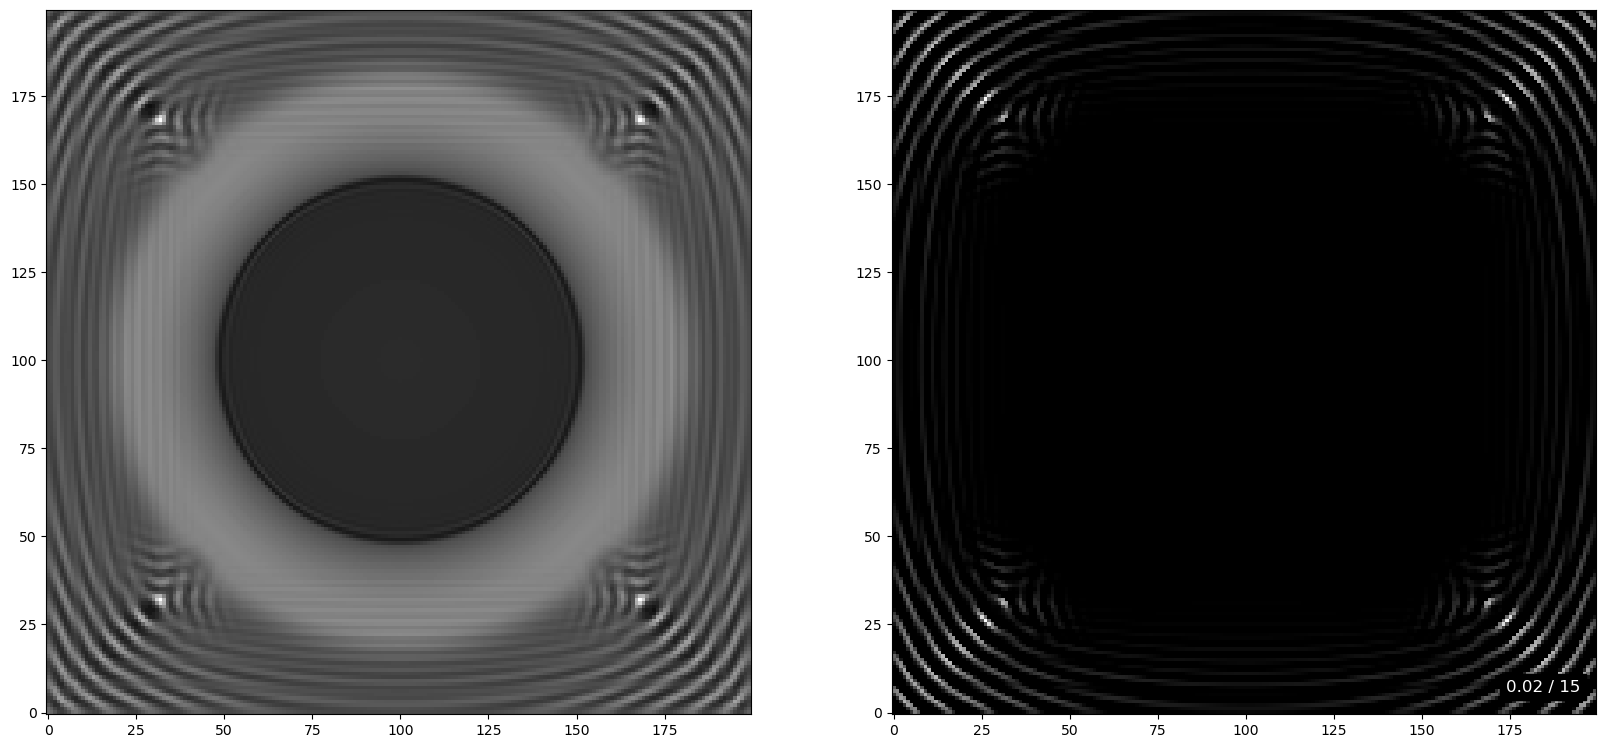

Total Mass Change: -1.796875e+00 [kg]
Total Momentum Change: [9.652344 9.640625] [kg·m/s]
Total Energy Change: -6.758400e+05 [J]
Total Mass Change: -1.796875e+00 [kg]
Total Momentum Change: [9.5703125 9.5859375] [kg·m/s]
Total Energy Change: -6.758400e+05 [J]


ValueError: [E] Value -3.003069e+02 at (172, 172) below clamp min 0.0 (tolerance=1.0)
All violating indices: [[172, 172]]

In [ ]:
ani = animation.FuncAnimation(fig, update, frames=int(TOTAL_T / FRAME_DT), interval=50, blit=True)

# mp4 저장 (ffmpeg 필요)
# libopenh264 버전 문제 회피: codec=None으로 두고 extra_args에서 직접 코덱 지정
writer = animation.FFMpegWriter(
    fps=80
)
ani.save("output.mp4", writer=writer)